# **Phase 3:** Attention + MLP + SMILES
---
In this notebook, we present our novel architecture, which operates by extracting the SMILES of a drug, tokenizing it with a sequential encoding, then distributing it to an attention-based model that uses 4 layers of attention, appending and sending to a downstream MLP


**Datasets**
- Clean-Balanced - Cleaned for small molcules and undersampled class 0
- Clean-Unbalanced - Cleaned for small molcules but 11-89 split.
- Dirty-Balanced - Original dataset but undersampled for class 0
- Dirty-Unbalanced - Original dataset with no undersampling

**Evalution**
- 5-Fold Cross Validation - Random state of 42 to ensure same split as previous Phase. 5-Fold CV ensures split of training data was not reason for metric variation
- Leave-One-Drug-Out Validation - Determine set of unique drugs -> choose 5 at random -> iterate 5 times, splitting dataset if drug in column A or column B was the chosen drug.
- Metrics - For 5-Fold CV, metrics were calculated on validation set for each fold and averaged across all folds. For LODO CV, metrics were calculated on teh set of data with the drug not in the training set and averaged across all folds. For the original metrics, metrics were simply calculated on the compoletely separate test set after training on all available data.

**NOTE:** This code was designed to run on an A100-High RAM environment with 12 CPU cores. If that is not the case, please modify/edit so that it doesn't error out.

---
**Graphical Abstract**

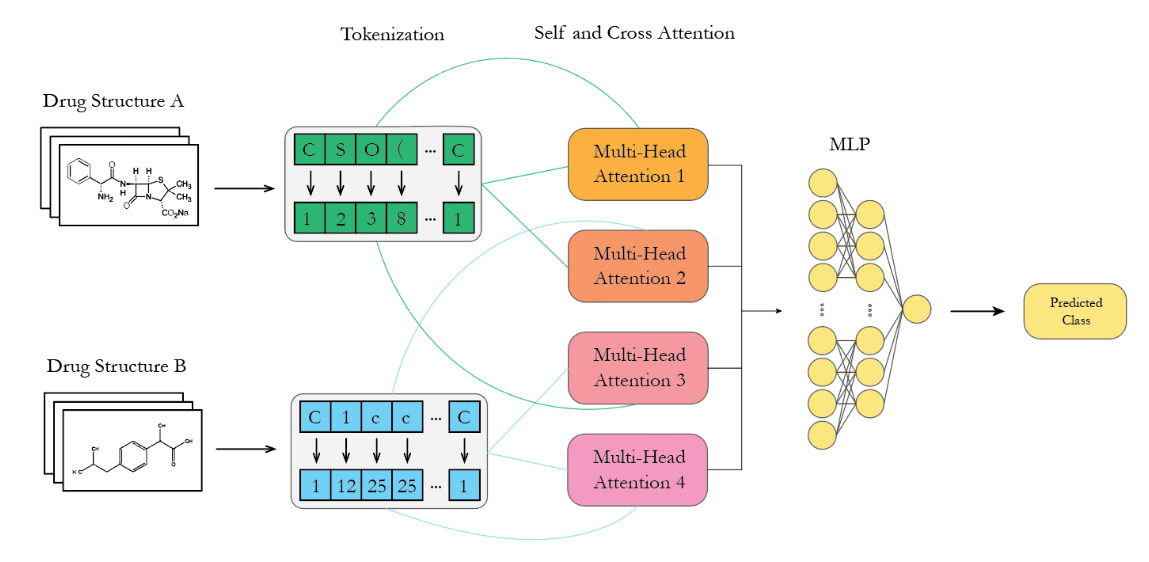

---

# Imports and Installs

## Installs

In [ ]:
# Installs
!pip install pytorch-lightning -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 54.0 MB/s eta 0:00:00


## Imports

In [ ]:
# Imports
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

## Mount Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Clean Train and Test Data

In [ ]:
# Load data for clean vs. unclean datasets
f_path = '/content/drive/MyDrive/BME 590 Final Project/Data/'

# Load clean train data
clean_train = pd.read_csv(f_path + 'clean_train_ddi.csv')
clean_train = clean_train.iloc[:, [3, 5, 6]]

# Rename columns
clean_train.columns = ['A', 'B', 'y']

# Display df
clean_train.head()

,A,B,y
0,CC12CCC3C(C1CCC2(C#C)O)CCC4=CC5=C(CC34C)C=NO5,CCN1CCN(C(=O)C1=O)C(=O)NC(C2=CC=CC=C2)C(=O)NC3...,0
1,CC(C)C1=C(C(=C(C(=N1)C(C)C)COC)C2=CC=C(C=C2)F)...,C(N)(N)(Cl)Cl,0
2,[O-]S(=O)(=O)[O-],CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,0
3,CC(=O)NC(CS)C(=O)O,C1=CC(=CC=C1COC(CN2C=CN=C2)C3=C(C=C(C=C3)Cl)Cl)Cl,0
4,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,CC#CCC(C)C(C=CC1C(CC2C1CC(=CCCCC(=O)O)C2)O)O,0


In [ ]:
# Load clean test data
clean_test = pd.read_csv(f_path + 'clean_test_ddi.csv')
clean_test = clean_test.iloc[:, [3, 5, 6]]

# Rename columns
clean_test.columns = ['A', 'B', 'y']

# Display df
clean_test.head()

,A,B,y
0,C1CC(N(C1)C(=O)C(CCCCN)NC(CCC2=CC=CC=C2)C(=O)O...,CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(...,1
1,CC1=CC=C(C=C1)C2=C(N3C=C(C=CC3=N2)C)CC(=O)N(C)C,CC1C(C(=O)N1S(=O)(=O)O)NC(=O)C(=NOC(C)(C)C(=O)...,0
2,CC(C)(C)C#CC=CCN(C)CC1=CC=CC2=CC=CC=C21,CC(C)NCC(COC1=CC=CC2=C1C=CN2)O,0
3,COC1=CC2=C(C=CN=C2C=C1)C(C3CC4CCN3CC4C=C)O,C1CCN(CC1)C2=NC(=NC3=C2N=C(N=C3N4CCCCC4)N(CCO)...,0
4,C1=NC(=NN1C2C(C(C(O2)CO)O)O)C(=O)N,C1CC(=O)NC2=C1C=CC(=C2)OCCCCN3CCN(CC3)C4=C(C(=...,0


## Load Dirty Train and Test Data

In [ ]:
# Load dirty train data
dirty_train = pd.read_csv(f_path + 'dirty_train_ddi.csv')
dirty_train = dirty_train.iloc[:, [3, 5, 6]]

# Rename columns
dirty_train.columns = ['A', 'B', 'y']

# Display df
dirty_train.head()

,A,B,y
0,CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(=O)CC4,CC(C)C1=C(C(=C(C(=N1)C(C)C)COC)C2=CC=C(C=C2)F)...,0
1,COC1=CC(=C(C=C1)OC)C(CNC(=O)CN)O,CC1=C(C(=CC=C1)NC2=CC=CC=C2C(=O)O)C,0
2,CCCCC1=NC2(CCCC2)C(=O)N1CC3=CC=C(C=C3)C4=CC=CC...,CC1=C(SC=N1)C=CC2=C(N3C(C(C3=O)NC(=O)C(=NOC)C4...,0
3,CN(CC(CO)O)C(=O)C1=C(C(=C(C(=C1I)C(=O)NCC(CO)O...,CN1CC(=O)N2C(C1=O)CC3=C(C2C4=CC5=C(C=C4)OCO5)N...,0
4,CC1=NN=C(S1)SCC2=C(N3C(C(C3=O)NC(=O)CN4C=NN=N4...,CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC...,0


In [ ]:
# Load dirty test data
dirty_test = pd.read_csv(f_path + 'dirty_test_ddi.csv')
dirty_test = dirty_test.iloc[:, [3, 5, 6]]

# Rename columns
dirty_test.columns = ['A', 'B', 'y']

# Display df
dirty_test.head()

,A,B,y
0,CCOC(=O)C(CCC1=CC=CC=C1)NC(C)C(=O)N2C3CCCC3CC2...,CC1=C(C(=CC=C1)NC2=CC=CC=C2C(=O)O)C,0
1,COC1=C(C(=NC=C1)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC(...,CCCCCN=C(N)NNC=C1C=NC2=C1C=C(C=C2)CO,0
2,CN1C2=C(C(=O)N(C1=O)C)NC=N2,C1CC2=C(C=CC(=C2)Cl)C(=C3CCNCC3)C4=C1C=CC=N4,0
3,CCC(=O)OC(C(C)C)OP(=O)(CCCCC1=CC=CC=C1)CC(=O)N...,C1CN2CCC1C(C2)OC(=O)N3CCC4=CC=CC=C4C3C5=CC=CC=C5,0
4,CN=C1CN(C(=C2C=C(C=CC2=N1)Cl)C3=CC=CC=C3)O,C1C(=NC(=O)N1N=CC2=CC=C(O2)C3=CC=C(C=C3)[N+](=...,0


# DataModule, Tokenizer, and Architecture

## Tokenizer

In [ ]:
# Custom tokenizer to embed SMILES into sequential encodings
class SMILESTokenizer:
    def __init__(self):

        # Create conversion dictionaries and stat for max string length
        self.char_to_index = {}
        self.index_to_char = {}
        self.max_length = 0

    def fit_on_texts(self, texts):

        # Define set of unique SMILES characters
        unique_chars = set()

        # For each SMILES
        for text in texts:

            # Add its unique letters to a set
            unique_chars.update(set(text))

            # Constantly update max length, if necessary
            if len(text) > self.max_length:
                self.max_length = len(text)

        # Sort unique characters
        unique_chars = sorted(list(unique_chars))

        # Create mapping from character to integer, leaving 0 for padding
        self.char_to_index = {char: i + 1 for i, char in enumerate(unique_chars)}  # + 1 for zero padding

        # Create mapping from integers to characters, for decoding
        self.index_to_char = {i: char for char, i in self.char_to_index.items()}

    # Method for actual conversion of SMILES to encodings
    def texts_to_sequences(self, texts):
        # Return list
        sequences = []

        # For each SMILES
        for text in texts:

            # Convert characters to integers
            sequence = [self.char_to_index[char] for char in text]

            # Append to return list
            sequences.append(sequence)

        # Return non-padded encodings
        return sequences

# Function to add 0s to end of SMILES that have characteristic len(SMILES) < max_len
def pad_sequences(sequences, maxlen):

    # Initialize padded array to save runtime
    padded_sequences = torch.zeros((len(sequences), maxlen), dtype = torch.int64)

    # For each non-padded sequence
    for i, sequence in enumerate(sequences):

        # Get end point of SMILES
        length = min(len(sequence), maxlen)

        # Add nonzero portion of SMILES to matrix
        padded_sequences[i, :length] = torch.tensor(sequence[:length])

    # Return matrix
    return padded_sequences

## DataModule

In [ ]:
# Define the actual data class to embed dataframes
class DrugInteractionDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df, tokenizer, max_length, batch_size = 512):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.batch_size = batch_size

    def setup(self, stage = None):
        # Process train data
        # Convert Drug A to tokens
        train_tokenized_A = self.tokenizer.texts_to_sequences(self.train_df['A'])

        # Convert Drug B to tokens
        train_tokenized_B = self.tokenizer.texts_to_sequences(self.train_df['B'])

        # Pad Drug A with 0s
        train_padded_A = pad_sequences(train_tokenized_A, self.max_length)

        # Pad Drug B with 0s
        train_padded_B = pad_sequences(train_tokenized_B, self.max_length)

        # Extract labels
        train_labels = torch.tensor(self.train_df['y'].values)

        # Create a TensorDataset
        self.train_dataset = TensorDataset(train_padded_A, train_padded_B, train_labels)

        # Process Validation data in similar fashion as above
        val_tokenized_A = self.tokenizer.texts_to_sequences(self.val_df['A'])
        val_tokenized_B = self.tokenizer.texts_to_sequences(self.val_df['B'])
        val_padded_A = pad_sequences(val_tokenized_A, self.max_length)
        val_padded_B = pad_sequences(val_tokenized_B, self.max_length)
        val_labels = torch.tensor(self.val_df['y'].values)
        self.val_dataset = TensorDataset(val_padded_A, val_padded_B, val_labels)

        # Process test data in similar fashion as above
        test_tokenized_A = self.tokenizer.texts_to_sequences(self.test_df['A'])
        test_tokenized_B = self.tokenizer.texts_to_sequences(self.test_df['B'])
        test_padded_A = pad_sequences(test_tokenized_A, self.max_length)
        test_padded_B = pad_sequences(test_tokenized_B, self.max_length)
        test_labels = torch.tensor(self.test_df['y'].values)
        self.test_dataset = TensorDataset(test_padded_A, test_padded_B, test_labels)

    # Create training dataloader
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers = 11, shuffle = True)

    # Create validation dataloader [Note: Change batch_size to len(self.val_df) if using leave-one-drug-out to avoid univariate class issues during evaluation]
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = len(self.val_dataset), num_workers = 11, shuffle = True)

    # Create test dataloader
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers = 11, shuffle = True)

## Model

In [ ]:
# Define the model
class DrugInteractionModel(pl.LightningModule):
    def __init__(self, vocab_size, embed_dim, max_length):
        super(DrugInteractionModel, self).__init__()
        self.criterion = nn.BCELoss()

        # Embedding layer converts tokenized SMILES to floating point embeddings of size embed_dim (arbitrary)
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Self Attention of A embeddings with themselves
        self.self_attention_A = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = 2, batch_first = True)

        # Self Attention of B embeddings with themselves
        self.self_attention_B = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = 2, batch_first = True)

        # Cross Attention of A embeddings with B embeddings
        self.cross_attention_AB = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = 2, batch_first = True)

        # Cross Attention of B embeddings with A embeddings
        self.cross_attention_BA = nn.MultiheadAttention(embed_dim = embed_dim, num_heads = 2, batch_first = True)

        # Downstream MLP of one fully connected layer to one output neuron
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * max_length * embed_dim, 1),
            nn.Sigmoid() # Outputs probability between 0 and 1 of being cassified as interacting (class 1)
        )

    # Feed forward method
    def forward(self, input_A, input_B):

        # This should be relatively straightforward. I personally would add skip connections here and just concatenate the embeddings
        # a priori; however, keeping this model simple
        embed_A = self.embedding(input_A)
        embed_B = self.embedding(input_B)
        self_attn_A, _ = self.self_attention_A(embed_A, embed_A, embed_A)
        self_attn_B, _ = self.self_attention_B(embed_B, embed_B, embed_B)
        cross_attn_AB, _ = self.cross_attention_AB(embed_A, embed_B, embed_B)
        cross_attn_BA, _ = self.cross_attention_BA(embed_B, embed_A, embed_A)

        # We simply concatenate all embeddings. Alternatively, we could take the mean
        concatenated = torch.cat([self_attn_A, self_attn_B, cross_attn_AB, cross_attn_BA], dim = 1)

        # Get predicted classes for concatenated embedding
        output = self.classifier(concatenated)
        return output

    # Calculate custom metrics
    def compute_metrics(self, outputs, labels):
        preds = torch.round(outputs.detach())  # Detach and binarize predictions
        labels = labels.detach()

        # Convert to CPU and NumPy
        preds_np = preds.cpu().numpy()
        labels_np = labels.cpu().numpy()

        # Calculate relevant metrics
        accuracy = accuracy_score(labels_np, preds_np)
        precision = precision_score(labels_np, preds_np, zero_division = 0) # zero_division sets cases of only one class to have 0 precision
        recall = recall_score(labels_np, preds_np, zero_division = 0) # zero_division sets cases of only one class to have 0 recall
        f1 = f1_score(labels_np, preds_np, zero_division = 0) # zero_division sets cases of only one class to have 0 f1 score
        balanced_acc = balanced_accuracy_score(labels_np, preds_np)
        auroc = roc_auc_score(labels_np, outputs.detach().cpu().numpy())  # For AUROC, use the raw outputs

        return accuracy, precision, recall, f1, balanced_acc, auroc

    # Define training step
    def training_step(self, batch, batch_idx):
        # Load batch
        A, B, labels = batch

        # Compute classes
        outputs = self(A, B)

        # Compute loss
        loss = self.criterion(outputs, labels.unsqueeze(1).float())

        # Other metrics
        accuracy, precision, recall, f1, balanced_acc, auroc = self.compute_metrics(outputs, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_auroc', auroc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_balance_acc', balanced_acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    # Log metrics on validation step
    def validation_step(self, batch, batch_idx):
        A, B, labels = batch
        outputs = self(A, B)
        loss = nn.BCELoss()(outputs, labels.unsqueeze(1).float())
        accuracy, precision, recall, f1, balanced_acc, auroc = self.compute_metrics(outputs, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_auroc', auroc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_balanced_acc', balanced_acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=True, on_epoch=True, prog_bar=True)

    # Log metrics on test step
    def test_step(self, batch, batch_idx):
        A, B, labels = batch
        outputs = self(A, B)
        loss = nn.BCELoss()(outputs, labels.unsqueeze(1).float())
        accuracy, precision, recall, f1, balanced_acc, auroc = self.compute_metrics(outputs, labels)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_auroc', auroc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_balanced_acc', balanced_acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_step=True, on_epoch=True, prog_bar=True)

    # Use Adam Optimizer (Try AdamW in future)
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.001)

# Evaluation

## Base Evaluation Method

In [ ]:
def train_and_evaluate(dataset, test_dataset, balance_data = True, max_epochs = 10):

    # Split dataset into training and validation
    train, val = train_test_split(dataset, test_size = 0.2, random_state = 42, shuffle = True)

    # Apply undersampling if balance_data is True
    if balance_data:
        undersampler = RandomUnderSampler(sampling_strategy = 'majority')
        X_train = train.drop(columns = ['y'])
        y_train = train['y']
        X_train, y_train = undersampler.fit_resample(X_train, y_train)
        train = pd.concat([X_train, y_train], axis = 1)

    # Tokenizer setup
    tokenizer = SMILESTokenizer()
    tokenizer.fit_on_texts(list(train['A']) + list(train['B']))
    max_length = tokenizer.max_length

    # Initialize DataModule and Model
    data_module = DrugInteractionDataModule(train, val, test_dataset, tokenizer, max_length)
    model = DrugInteractionModel(vocab_size = len(tokenizer.char_to_index) + 1, embed_dim = 64, max_length = max_length)

    # Train the model
    trainer = pl.Trainer(max_epochs = max_epochs)
    trainer.fit(model, data_module)

    # Evaluate the model on the test set
    trainer.test(model, datamodule = data_module)

    # Extract and return metrics
    metrics = trainer.logged_metrics

    return metrics

In [ ]:
# Train each model on all training data from random split and test on actual test set
clean_metrics_balanced = train_and_evaluate(clean_train, clean_test, balance_data = True)
clean_metrics_unbalanced = train_and_evaluate(clean_train, clean_test, balance_data = False)
dirty_metrics_balanced = train_and_evaluate(dirty_train, dirty_test, balance_data = True)
dirty_metrics_unbalanced = train_and_evaluate(dirty_train, dirty_test, balance_data = False)

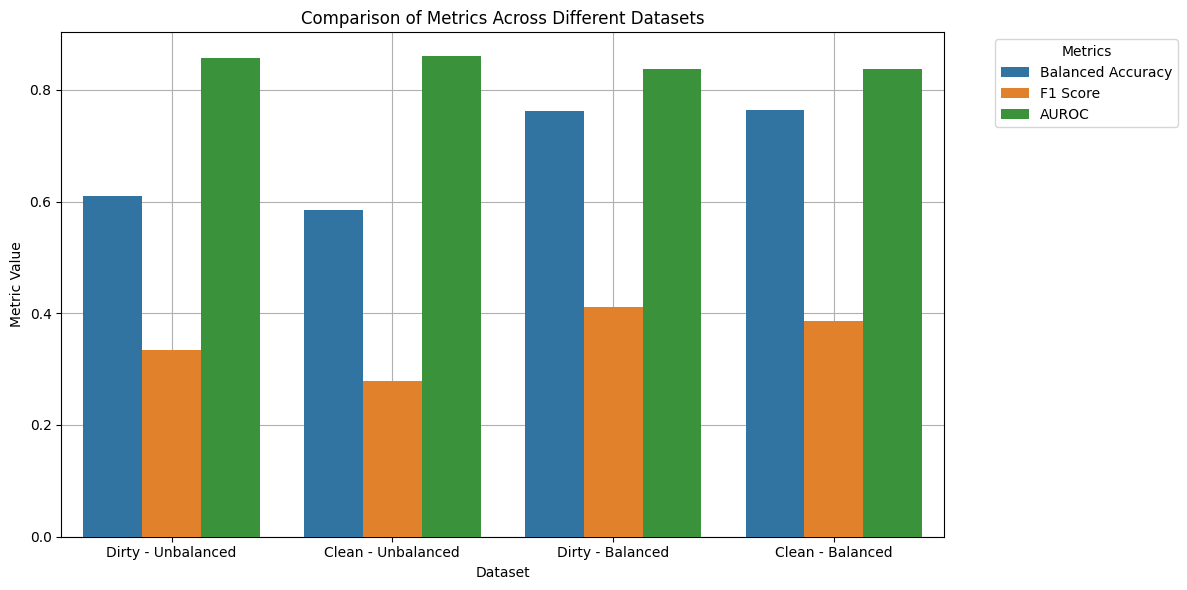

In [ ]:
# This reformats and extracts the tensor values as floats
def format_metrics(metrics_dict, metrics_to_extract):
    formatted_dict = {}
    for key in metrics_to_extract:

        # Extracting the metric if it exists in the dictionary and is a tensor
        value = metrics_dict.get(key)
        if torch.is_tensor(value):
            formatted_dict[key] = value.item()

    # Return correct dictionary format
    return formatted_dict

# Metrics to extract
metrics_to_extract = ['test_balanced_acc_epoch', 'test_f1_epoch', 'test_auroc_epoch']

# Format these dictionaries
formatted_clean_balanced = format_metrics(clean_metrics_balanced, metrics_to_extract)
formatted_clean_unbalanced = format_metrics(clean_metrics_unbalanced, metrics_to_extract)
formatted_dirty_balanced = format_metrics(dirty_metrics_balanced, metrics_to_extract)
formatted_dirty_unbalanced = format_metrics(dirty_metrics_unbalanced, metrics_to_extract)

# Sample data from the dictionaries
data = {
    "Dirty - Unbalanced": formatted_dirty_unbalanced,
    "Clean - Unbalanced": formatted_clean_unbalanced,
    "Dirty - Balanced": formatted_dirty_balanced,
    "Clean - Balanced": formatted_clean_balanced
}

# Convert dictionary to a DataFrame suitable for Seaborn
df = pd.DataFrame(data).T.reset_index()

# Melt to conver to for seaborn plotting
df = pd.melt(df, id_vars = ["index"], var_name = "Metric", value_name = "Value")

# Rname data
df.rename(columns = {"index": "Dataset"}, inplace = True)

# Renaming the metrics for better readability
metric_name_map = {
    'test_balanced_acc_epoch': 'Balanced Accuracy',
    'test_f1_epoch': 'F1 Score',
    'test_auroc_epoch': 'AUROC'
}

# Set legend values
df['Metric'] = df['Metric'].map(metric_name_map)

# Plotting
fig, ax = plt.subplots(figsize = (12, 6))

# Plot results
sns.barplot(x = "Dataset",
            y = "Value",
            hue = "Metric",
            data = df,
            ax = ax,
            zorder = 4)

# Label Plots
ax.set(title = "Comparison of Metrics Across Different Datasets",
       xlabel = 'Dataset',
       ylabel = 'Metric Value')

# Add grid
ax.grid(zorder = 0)

# Add Legend
ax.legend(title = "Metrics", bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Tight layout
plt.tight_layout()
plt.show()

# Save figure
fig.savefig('Attention_Performance.png', dpi = 600)

## K-Fold Cross Validation

In [ ]:
# Training method for K-Fold validation
def train_and_evaluate_kfold(dataset, test_dataset, balance_data = True, max_epochs = 10, n_splits = 5):

    # Initialize KFold splitter
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

    # Array to store metrics of each fold
    fold_metrics = []

    # For each fold
    for train_index, val_index in kf.split(dataset):

        # Split the trianing and validation
        train, val = dataset.iloc[train_index], dataset.iloc[val_index]

        # If we need to balance the data
        if balance_data:

            # Initialize undersampler
            undersampler = RandomUnderSampler(sampling_strategy = 'majority')
            X_train = train.drop(columns = ['y'])
            y_train = train['y']
            X_train, y_train = undersampler.fit_resample(X_train, y_train)
            train = pd.concat([X_train, y_train], axis = 1)

        tokenizer = SMILESTokenizer()
        tokenizer.fit_on_texts(list(train['A']) + list(train['B']))
        max_length = tokenizer.max_length

        data_module = DrugInteractionDataModule(train, val, test_dataset, tokenizer, max_length)
        model = DrugInteractionModel(vocab_size = len(tokenizer.char_to_index) + 1, embed_dim = 64, max_length = max_length)

        trainer = pl.Trainer(max_epochs = max_epochs)
        trainer.fit(model, data_module)

        # Evaluate on the validation set
        val_result = trainer.validate(model, dataloaders = data_module)
        fold_metrics.append(val_result[0])

        metrics = trainer.logged_metrics
        fold_metrics.append(metrics)

    # Average metrics across folds
    avg_metrics = {metric: np.mean([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0].keys()}
    return avg_metrics

In [ ]:
# Train each model on 5 fold cross-validation, averaging the results across each fold
clean_metrics_balanced_k = train_and_evaluate_kfold(clean_train, clean_test, balance_data = True)
clean_metrics_unbalanced_k = train_and_evaluate_kfold(clean_train, clean_test, balance_data = False)
dirty_metrics_balanced_k = train_and_evaluate_kfold(dirty_train, dirty_test, balance_data = True)
dirty_metrics_unbalanced_k = train_and_evaluate_kfold(dirty_train, dirty_test, balance_data = False)

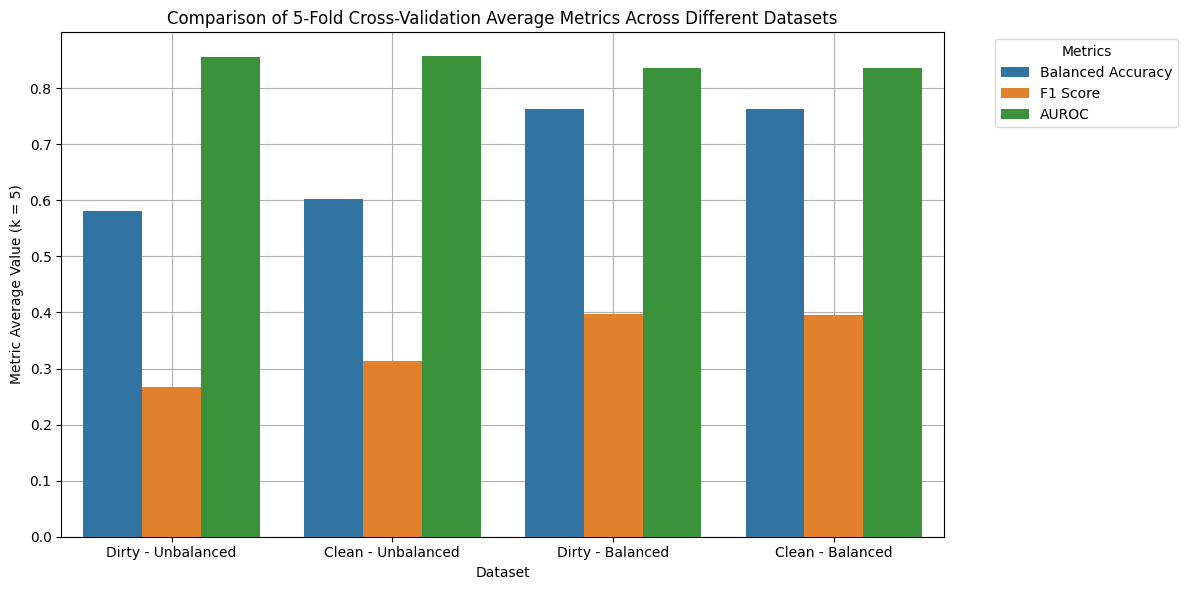

In [ ]:
# Plotting code for k-fold validation
# This reformats and extracts the tensor values as floats
def format_metrics(metrics_dict, metrics_to_extract):
    formatted_dict = {}
    for key in metrics_to_extract:

        # Extracting the metric if it exists in the dictionary and is a tensor
        value = metrics_dict.get(key)
        formatted_dict[key] = value

    # Return correct dictionary format
    return formatted_dict

# Metrics to extract
metrics_to_extract = ['val_balanced_acc_epoch', 'val_f1_epoch', 'val_auroc_epoch']

# Format these dictionaries
formatted_clean_balanced = format_metrics(clean_metrics_balanced_k, metrics_to_extract)
formatted_clean_unbalanced = format_metrics(clean_metrics_unbalanced_k, metrics_to_extract)
formatted_dirty_balanced = format_metrics(dirty_metrics_balanced_k, metrics_to_extract)
formatted_dirty_unbalanced = format_metrics(dirty_metrics_unbalanced_k, metrics_to_extract)

# Sample data from the dictionaries
data = {
    "Dirty - Unbalanced": formatted_dirty_unbalanced,
    "Clean - Unbalanced": formatted_clean_unbalanced,
    "Dirty - Balanced": formatted_dirty_balanced,
    "Clean - Balanced": formatted_clean_balanced
}

# Convert dictionary to a DataFrame suitable for Seaborn
df = pd.DataFrame(data).T.reset_index()

# Melt to conver to for seaborn plotting
df = pd.melt(df, id_vars = ["index"], var_name = "Metric", value_name = "Value")

# Rname data
df.rename(columns = {"index": "Dataset"}, inplace = True)

# Renaming the metrics for better readability
metric_name_map = {
    'val_balanced_acc_epoch': 'Balanced Accuracy',
    'val_f1_epoch': 'F1 Score',
    'val_auroc_epoch': 'AUROC'
}

# Set legend values
df['Metric'] = df['Metric'].map(metric_name_map)

# Plotting
fig, ax = plt.subplots(figsize = (12, 6))

# Plot results
sns.barplot(x = "Dataset",
            y = "Value",
            hue = "Metric",
            data = df,
            ax = ax,
            zorder = 4)

# Label Plots
ax.set(title = "Comparison of 5-Fold Cross-Validation Average Metrics Across Different Datasets",
       xlabel = 'Dataset',
       ylabel = 'Metric Average Value (k = 5)')

# Add grid
ax.grid(zorder = 0)

# Add Legend
ax.legend(title = "Metrics", bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Tight layout
plt.tight_layout()
plt.show()

# Save figure
fig.savefig('Attention_Performance_kfold.png', dpi = 600)

## Leave-One-Out Cross Validation

In [ ]:
# Method for leave-one-out cross validation
def train_and_evaluate_leave_one_drug_out(dataset, test_df, balance_data = True, max_epochs = 10, num_drugs = 5, random_state = 42):
    # Set the random seed for reproducibility
    random.seed(random_state)

    # Combine unique drugs from columns 'A' and 'B'
    unique_drugs_A = set(dataset['A'].unique())
    unique_drugs_B = set(dataset['B'].unique())
    combined_unique_drugs = unique_drugs_A.union(unique_drugs_B)

    # Randomly select five drugs
    selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))

    fold_metrics = []
    for drug in selected_drugs:

        # Create a validation set where the drug appears in either 'A' or 'B'
        val = dataset[(dataset['A'] == drug) | (dataset['B'] == drug)]
        # Create a training set excluding those rows
        train = dataset[(dataset['A'] != drug) & (dataset['B'] != drug)]

        if balance_data:
            undersampler = RandomUnderSampler(sampling_strategy='majority')
            X_train = train.drop(columns=['y'])
            y_train = train['y']
            X_train, y_train = undersampler.fit_resample(X_train, y_train)
            train = pd.concat([X_train, y_train], axis=1)

        tokenizer = SMILESTokenizer()
        tokenizer.fit_on_texts(list(train['A']) + list(train['B']))
        max_length = tokenizer.max_length

        data_module = DrugInteractionDataModule(train, val, test_df, tokenizer, max_length)
        model = DrugInteractionModel(vocab_size=len(tokenizer.char_to_index) + 1, embed_dim=64, max_length=max_length)

        trainer = pl.Trainer(max_epochs=max_epochs)
        trainer.fit(model, data_module)

        # Evaluate on the validation set
        val_result = trainer.validate(model, dataloaders=data_module.val_dataloader())
        fold_metrics.append(val_result[0])

    # Average metrics across folds
    avg_metrics = {metric: np.mean([fm[metric] for fm in fold_metrics]) for metric in fold_metrics[0].keys()}
    return avg_metrics

In [ ]:
# Train each model on 5 fold cross-validation, averaging the results across each fold
clean_metrics_balanced_k_one_out = train_and_evaluate_leave_one_drug_out(clean_train, clean_test, balance_data = True)

<ipython-input-11-7bad4d3b43ab>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.4692982456140351     │
│      val_auroc_epoch      │    0.7697746697746698     │
│  val_balanced_acc_epoch   │     0.651981351981352     │
│       val_f1_epoch        │    0.3314917127071823     │
│      val_loss_epoch       │    0.9082249402999878     │
│    val_precision_epoch    │    0.20270270270270271    │
│     val_recall_epoch      │     0.909090909090909     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.6984478935698448     │
│      val_auroc_epoch      │    0.7414563323654233     │
│  val_balanced_acc_epoch   │    0.6707616707616708     │
│       val_f1_epoch        │    0.2916666666666667     │
│      val_loss_epoch       │    0.5712812542915344     │
│    val_precision_epoch    │    0.18918918918918917    │
│     val_recall_epoch      │    0.6363636363636364     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8675213675213675     │
│      val_auroc_epoch      │     0.722914669223394     │
│  val_balanced_acc_epoch   │    0.6810482582294664     │
│       val_f1_epoch        │    0.24390243902439024    │
│      val_loss_epoch       │    0.3566072881221771     │
│    val_precision_epoch    │    0.16393442622950818    │
│     val_recall_epoch      │    0.47619047619047616    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.3435448577680525     │
│      val_auroc_epoch      │    0.7879226601905474     │
│  val_balanced_acc_epoch   │     0.620516532785354     │
│       val_f1_epoch        │    0.25742574257425743    │
│      val_loss_epoch       │    1.2061465978622437     │
│    val_precision_epoch    │    0.14814814814814814    │
│     val_recall_epoch      │    0.9811320754716981     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.6751054852320675     │
│      val_auroc_epoch      │    0.5610132158590309     │
│  val_balanced_acc_epoch   │    0.5436123348017621     │
│       val_f1_epoch        │    0.09411764705882353    │
│      val_loss_epoch       │    0.6128778457641602     │
│    val_precision_epoch    │    0.05333333333333334    │
│     val_recall_epoch      │            0.4            │
└───────────────────────────┴───────────────────────────┘

In [ ]:
clean_metrics_unbalanced_k_one_out = train_and_evaluate_leave_one_drug_out(clean_train, clean_test, balance_data = False, random_state = 43)

<ipython-input-15-2ac7fe6820fd>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.7616033755274262     │
│      val_auroc_epoch      │    0.7085039143862674     │
│  val_balanced_acc_epoch   │     0.525712849242261     │
│       val_f1_epoch        │    0.11023622047244094    │
│      val_loss_epoch       │    0.5966786742210388     │
│    val_precision_epoch    │            0.7            │
│     val_recall_epoch      │    0.05982905982905983    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8816067653276956     │
│      val_auroc_epoch      │    0.7918807810894142     │
│  val_balanced_acc_epoch   │    0.5077295306611853     │
│       val_f1_epoch        │    0.03448275862068965    │
│      val_loss_epoch       │    0.3259049654006958     │
│    val_precision_epoch    │            0.5            │
│     val_recall_epoch      │   0.017857142857142856    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9307359307359307     │
│      val_auroc_epoch      │    0.7269195451013634     │
│  val_balanced_acc_epoch   │    0.5151515151515151     │
│       val_f1_epoch        │    0.05882352941176471    │
│      val_loss_epoch       │    0.23707018792629242    │
│    val_precision_epoch    │            1.0            │
│     val_recall_epoch      │   0.030303030303030304    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8583690987124464     │
│      val_auroc_epoch      │    0.7632196969696969     │
│  val_balanced_acc_epoch   │            0.5            │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.3947432339191437     │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.0 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 52.7 K
----------------------------------------------------------
121

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9477124183006536     │
│      val_auroc_epoch      │    0.8041002277904328     │
│  val_balanced_acc_epoch   │    0.5193052391799544     │
│       val_f1_epoch        │    0.07692307692307693    │
│      val_loss_epoch       │    0.1963142305612564     │
│    val_precision_epoch    │    0.16666666666666666    │
│     val_recall_epoch      │           0.05            │
└───────────────────────────┴───────────────────────────┘

In [ ]:
dirty_metrics_balanced_k_one_out = train_and_evaluate_leave_one_drug_out(dirty_train, dirty_test, balance_data = True)

<ipython-input-15-2ac7fe6820fd>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.5904365904365905     │
│      val_auroc_epoch      │    0.7412426560248309     │
│  val_balanced_acc_epoch   │    0.6725557033588294     │
│       val_f1_epoch        │    0.4322766570605187     │
│      val_loss_epoch       │    0.6991692781448364     │
│    val_precision_epoch    │    0.2952755905511811     │
│     val_recall_epoch      │    0.8064516129032258     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.5560253699788583     │
│      val_auroc_epoch      │    0.8460721868365181     │
│  val_balanced_acc_epoch   │    0.7770700636942676     │
│       val_f1_epoch        │   0.018691588785046728    │
│      val_loss_epoch       │    0.7602035999298096     │
│    val_precision_epoch    │   0.009433962264150943    │
│     val_recall_epoch      │            1.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │     0.547568710359408     │
│      val_auroc_epoch      │    0.39477927837129606    │
│  val_balanced_acc_epoch   │    0.35199556541019955    │
│       val_f1_epoch        │    0.02727272727272728    │
│      val_loss_epoch       │    0.8066760897636414     │
│    val_precision_epoch    │   0.015151515151515152    │
│     val_recall_epoch      │    0.13636363636363635    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.6098081023454158     │
│      val_auroc_epoch      │    0.7077192982456141     │
│  val_balanced_acc_epoch   │    0.6706432748538012     │
│       val_f1_epoch        │    0.13270142180094788    │
│      val_loss_epoch       │    0.6928832530975342     │
│    val_precision_epoch    │    0.07291666666666667    │
│     val_recall_epoch      │    0.7368421052631579     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8690228690228691     │
│      val_auroc_epoch      │    0.8809523809523809     │
│  val_balanced_acc_epoch   │    0.7927968655816757     │
│       val_f1_epoch        │    0.13698630136986303    │
│      val_loss_epoch       │    0.36076977849006653    │
│    val_precision_epoch    │    0.07575757575757576    │
│     val_recall_epoch      │    0.7142857142857143     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
dirty_metrics_unbalanced_k_one_out = train_and_evaluate_leave_one_drug_out(dirty_train, dirty_test, balance_data = False, random_state = 43)

<ipython-input-19-49d77dd639fe>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_drugs = random.sample(combined_unique_drugs, min(num_drugs, len(combined_unique_drugs)))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8066528066528067     │
│      val_auroc_epoch      │    0.7527990244983926     │
│  val_balanced_acc_epoch   │            0.5            │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.5395299792289734     │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9894291754756871     │
│      val_auroc_epoch      │    0.8312101910828026     │
│  val_balanced_acc_epoch   │    0.4968152866242038     │
│       val_f1_epoch        │            0.0            │
│      val_loss_epoch       │    0.09666865319013596    │
│    val_precision_epoch    │            0.0            │
│     val_recall_epoch      │            0.0            │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9429175475687104     │
│      val_auroc_epoch      │    0.9332795807296916     │
│  val_balanced_acc_epoch   │     0.602549889135255     │
│       val_f1_epoch        │    0.27027027027027023    │
│      val_loss_epoch       │    0.1700056791305542     │
│    val_precision_epoch    │    0.3333333333333333     │
│     val_recall_epoch      │    0.22727272727272727    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.8827292110874201     │
│      val_auroc_epoch      │    0.8610526315789474     │
│  val_balanced_acc_epoch   │    0.7120467836257309     │
│       val_f1_epoch        │    0.26666666666666666    │
│      val_loss_epoch       │    0.32081425189971924    │
│    val_precision_epoch    │    0.17857142857142858    │
│     val_recall_epoch      │    0.5263157894736842     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params
----------------------------------------------------------
0 | criterion          | BCELoss            | 0     
1 | embedding          | Embedding          | 2.7 K 
2 | self_attention_A   | MultiheadAttention | 16.6 K
3 | self_attention_B   | MultiheadAttention | 16.6 K
4 | cross_attention_AB | MultiheadAttention | 16.6 K
5 | cross_attention_BA | MultiheadAttention | 16.6 K
6 | classifier         | Sequential         | 58.4 K
----------------------------------------------------------
127

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9875259875259875     │
│      val_auroc_epoch      │    0.9475587703435805     │
│  val_balanced_acc_epoch   │    0.5714285714285714     │
│       val_f1_epoch        │           0.25            │
│      val_loss_epoch       │    0.09712982177734375    │
│    val_precision_epoch    │            1.0            │
│     val_recall_epoch      │    0.14285714285714285    │
└───────────────────────────┴───────────────────────────┘

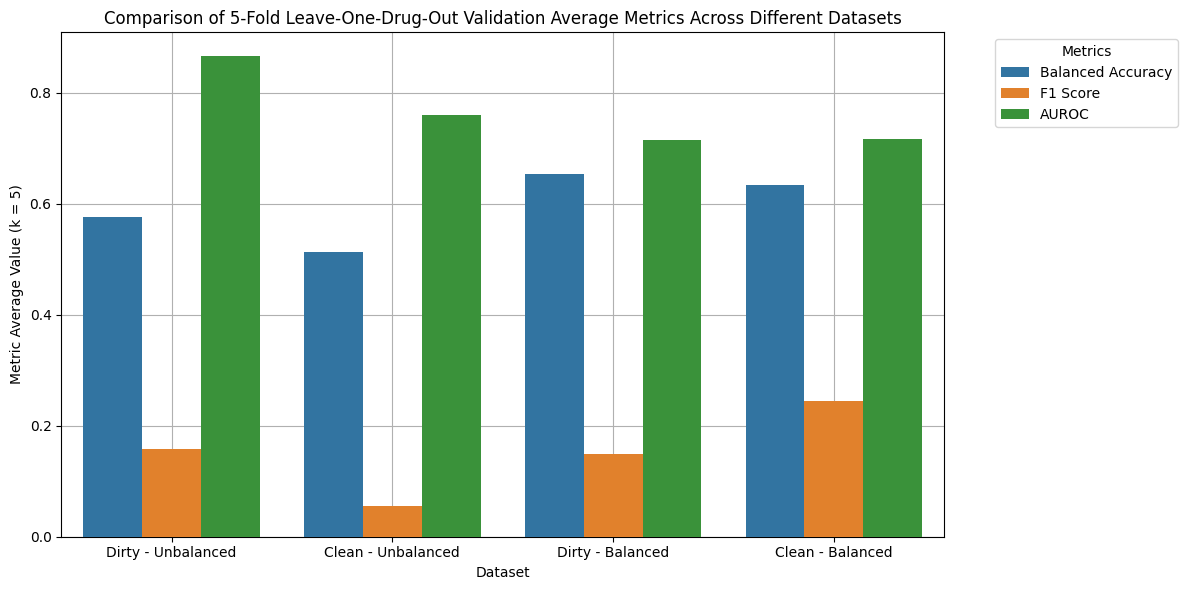

In [ ]:
# Plotting code for leave one out
# This reformats and extracts the tensor values as floats
def format_metrics(metrics_dict, metrics_to_extract):
    formatted_dict = {}
    for key in metrics_to_extract:

        # Extracting the metric if it exists in the dictionary and is a tensor
        value = metrics_dict.get(key)
        formatted_dict[key] = value

    # Return correct dictionary format
    return formatted_dict

# Metrics to extract
metrics_to_extract = ['val_balanced_acc_epoch', 'val_f1_epoch', 'val_auroc_epoch']

# Format these dictionaries
formatted_clean_balanced = format_metrics(clean_metrics_balanced_k_one_out, metrics_to_extract)
formatted_clean_unbalanced = format_metrics(clean_metrics_unbalanced_k_one_out, metrics_to_extract)
formatted_dirty_balanced = format_metrics(dirty_metrics_balanced_k_one_out, metrics_to_extract)
formatted_dirty_unbalanced = format_metrics(dirty_metrics_unbalanced_k_one_out, metrics_to_extract)

# Sample data from the dictionaries
data = {
    "Dirty - Unbalanced": formatted_dirty_unbalanced,
    "Clean - Unbalanced": formatted_clean_unbalanced,
    "Dirty - Balanced": formatted_dirty_balanced,
    "Clean - Balanced": formatted_clean_balanced
}

# Convert dictionary to a DataFrame suitable for Seaborn
df = pd.DataFrame(data).T.reset_index()

# Melt to conver to for seaborn plotting
df = pd.melt(df, id_vars = ["index"], var_name = "Metric", value_name = "Value")

# Rname data
df.rename(columns = {"index": "Dataset"}, inplace = True)

# Renaming the metrics for better readability
metric_name_map = {
    'val_balanced_acc_epoch': 'Balanced Accuracy',
    'val_f1_epoch': 'F1 Score',
    'val_auroc_epoch': 'AUROC'
}

# Set legend values
df['Metric'] = df['Metric'].map(metric_name_map)

# Plotting
fig, ax = plt.subplots(figsize = (12, 6))

# Plot results
sns.barplot(x = "Dataset",
            y = "Value",
            hue = "Metric",
            data = df,
            ax = ax,
            zorder = 4)

# Label Plots
ax.set(title = "Comparison of 5-Fold Leave-One-Drug-Out Validation Average Metrics Across Different Datasets",
       xlabel = 'Dataset',
       ylabel = 'Metric Average Value (k = 5)')

# Add grid
ax.grid(zorder = 0)

# Add Legend
ax.legend(title = "Metrics", bbox_to_anchor = (1.05, 1), loc = 'upper left')

# Tight layout
plt.tight_layout()
plt.show()

# Save figure
fig.savefig('Attention_Performance_kfold_one_out.png', dpi = 600)

In [ ]:
# If desired, load tensorboard to visualize all logged metrics (If this doesn't work, use weights and biases or modify code to plot manually)
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

# Discussion

When we observe the performance of the model, we notice immediately that there is little difference between the clean and unclean datasets; this is likely a result of the fact that very few data entries needed cleaning.

We also observe that the balancing (undersampling) significantly increases performance across the board, biggest differences seen in F1 score and balanced accuracy.

As for the architectures, we note that the Attention (Phase 3) architecture does better on imbalanced datasets than either the base (Phase 1) or the mid-tier (Phase 2) model, and does roughly the same as Morgan fingerprints for the 5-fold CV and standard testing.

Results for Leave-One-Drug-Out are all over the place, reflecting the fact that it highly depends on what drug is chosen and ideally all drugs should be tested. Additionally, with tokenization, the validation drug can error out if the token in the SMILES was not seen in the training data. For example the letter "a" only shows up in salt-containing SMILES, so it can cause a key error. Lastly, sometimes the imbalanced nature of the dataset necessitates updating the batch size to encompass the whole validation batch so that there is at least 1 positive value.

A big bias of this dataset is that there is always some interaction of a drug. I.e. there are no drugs with no interacting value, which is not realistic. Additonally, our assumption that the drugs not present are 0s is not necessarily valid.